In [5]:
!pip install -q ultralytics opencv-python-headless matplotlib scikit-learn torch torchvision

import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
from torchvision import models, transforms
from sklearn.cluster import KMeans
import urllib.request

print(f"CUDA Available: {torch.cuda.is_available()}")

# Utility function to display images in Colab
def show_image(img, title="Image", figsize=(10, 8)):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=figsize)
    plt.imshow(img_rgb)
    plt.title(title)
    plt.axis("off")
    plt.show()

CUDA Available: False



image 1/1 /Users/manii/Desktop/Detect/ppe-dataset/test/images/-19-_png_jpg.rf.8a95af32ef6a4a1a99576a0498997efa.jpg: 640x640 5 persons, 55.2ms
Speed: 1.4ms preprocess, 55.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


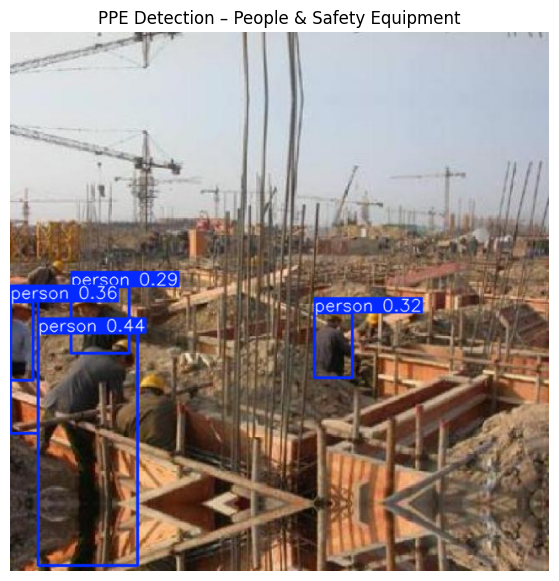

In [6]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import os

# Load YOLOv8 lightweight model
model = YOLO("yolov8n.pt")

# Use RELATIVE path (portable)
img_path = "ppe-dataset/test/images/-19-_png_jpg.rf.8a95af32ef6a4a1a99576a0498997efa.jpg"

# Safety check
assert os.path.exists(img_path), "Image path not found"

# Read image
img = cv2.imread(img_path)

# Run inference
results = model(img_path)

# Visualize detections
annotated = results[0].plot()
annotated = cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 7))
plt.imshow(annotated)
plt.title("PPE Detection – People & Safety Equipment")
plt.axis("off")
plt.show()


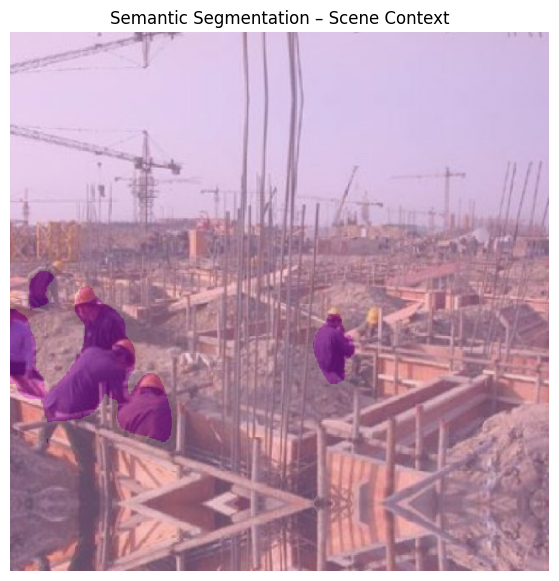

In [10]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchvision import models, transforms

# Convert BGR → RGB (VERY IMPORTANT)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Load DeepLabV3 (updated API)
model_seg = models.segmentation.deeplabv3_resnet50(
    weights=models.segmentation.DeepLabV3_ResNet50_Weights.DEFAULT
)
model_seg.eval()

if torch.cuda.is_available():
    model_seg = model_seg.cuda()

# Preprocessing
preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((520, 520)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

input_tensor = preprocess(img_rgb).unsqueeze(0)

if torch.cuda.is_available():
    input_tensor = input_tensor.cuda()

# Inference
with torch.no_grad():
    output = model_seg(input_tensor)["out"][0]

# Segmentation mask
mask = output.argmax(0).cpu().numpy()

# Resize mask back to original image size
mask_resized = cv2.resize(
    mask, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST
)

# Create color map
colors = np.random.randint(0, 255, (21, 3))
seg_rgb = colors[mask_resized]

# Overlay
overlay = cv2.addWeighted(img_rgb, 0.6, seg_rgb.astype("uint8"), 0.4, 0)

# Display
plt.figure(figsize=(10, 7))
plt.imshow(overlay)
plt.title("Semantic Segmentation – Scene Context")
plt.axis("off")
plt.show()


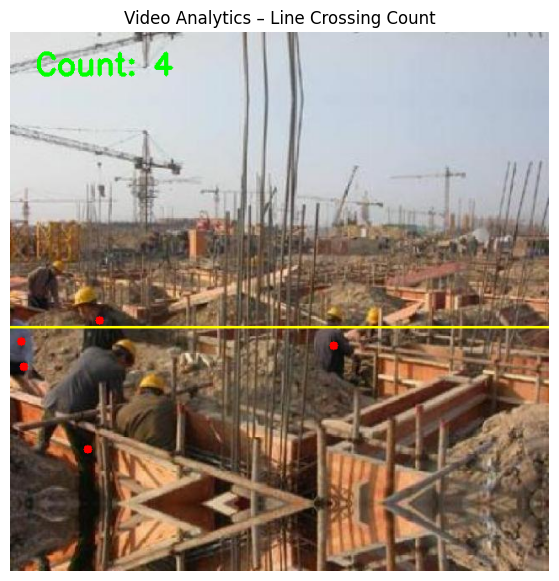

In [8]:
line_y = 350
count = 0
analytics_img = img.copy()

# Draw virtual line
cv2.line(analytics_img, (0, line_y),
         (analytics_img.shape[1], line_y),
         (0, 255, 255), 2)

boxes = results[0].boxes.xywh.cpu().numpy()
classes = results[0].boxes.cls.cpu().numpy()

for box, cls in zip(boxes, classes):
    if int(cls) == 0:  # person class
        x, y, w, h = box
        cx, cy = int(x), int(y)

        if cy > line_y:
            count += 1

        cv2.circle(analytics_img, (cx, cy), 5, (0, 0, 255), -1)

cv2.putText(analytics_img, f"Count: {count}",
            (30, 50), cv2.FONT_HERSHEY_SIMPLEX,
            1.2, (0, 255, 0), 3)

plt.figure(figsize=(10, 7))
plt.imshow(cv2.cvtColor(analytics_img, cv2.COLOR_BGR2RGB))
plt.title("Video Analytics – Line Crossing Count")
plt.axis("off")
plt.show()


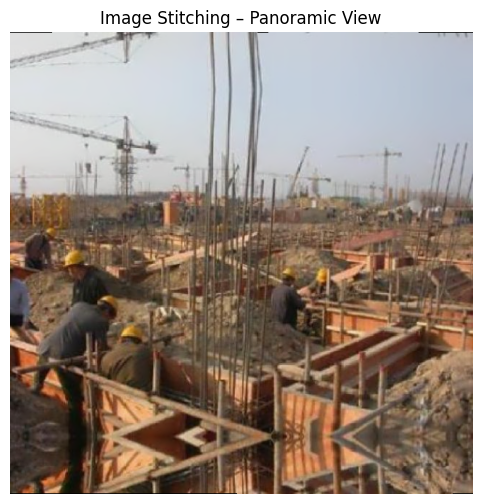

In [9]:
# Simulate two camera views by splitting PPE image
h, w, _ = img.shape
left = img[:, :w//2 + 80]
right = img[:, w//2 - 80:]

stitcher = cv2.Stitcher_create()
status, stitched = stitcher.stitch([left, right])

if status == cv2.Stitcher_OK:
    plt.figure(figsize=(12, 6))
    plt.imshow(cv2.cvtColor(stitched, cv2.COLOR_BGR2RGB))
    plt.title("Image Stitching – Panoramic View")
    plt.axis("off")
    plt.show()
else:
    print("Stitching failed (low overlap)")


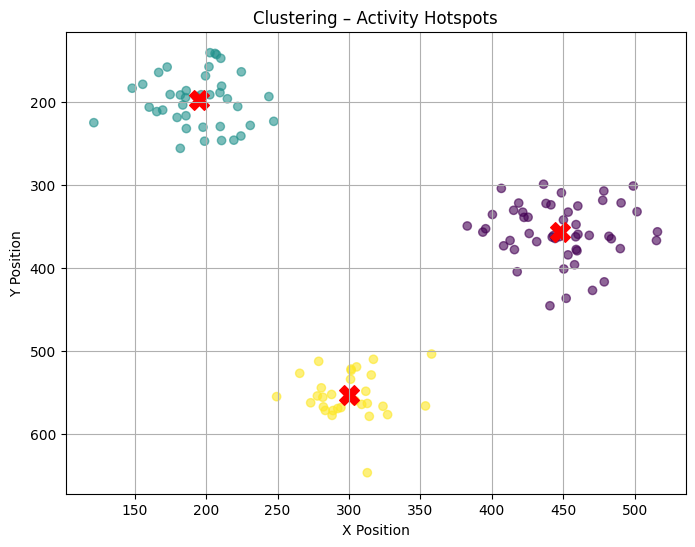

In [11]:
from sklearn.cluster import KMeans
import numpy as np

# Simulated object centroids over time
np.random.seed(42)
centroids = np.vstack([
    np.random.normal([200, 200], 30, (40, 2)),
    np.random.normal([450, 350], 35, (50, 2)),
    np.random.normal([300, 550], 25, (30, 2))
])

kmeans = KMeans(n_clusters=3, random_state=0, n_init=10)
labels = kmeans.fit_predict(centroids)

plt.figure(figsize=(8, 6))
plt.scatter(centroids[:, 0], centroids[:, 1],
            c=labels, cmap="viridis", alpha=0.6)
plt.scatter(kmeans.cluster_centers_[:, 0],
            kmeans.cluster_centers_[:, 1],
            c="red", s=200, marker="X")
plt.title("Clustering – Activity Hotspots")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.gca().invert_yaxis()
plt.grid(True)
plt.show()
